# Reconocimiento Facial con Machine Learning para Seguridad

En este proyecto se desarrolla un sistema de **reconocimiento facial** basado en modelos de *machine learning*, cuyo objetivo es identificar **personas autorizadas** en un entorno de seguridad utilizando **cámaras de videovigilancia** que capturan imágenes en tiempo real.

El sistema esta pensado para procesar cada frame capturado por las cámaras y mediante un algoritmo de **clasificación de rostros**, determinando si la persona detectada pertenece al grupo de individuos autorizados o no.

Adicionalmente, se busca extender el análisis para **identificar el género** de la persona, enriqueciendo así la información registrada por el sistema. Esta característica puede utilizarse como:
- Capa adicional de validación de identidad,
- Generación de estadísticas de acceso,
- O implementación de políticas específicas basadas en demografía.

## Objetivo

- Desarrollar un sistema de **identificación facial automática** para controlar el acceso a zonas seguras.
- Clasificar los rostros capturados no solo por identidad, sino también por **género**.
- Crear un pipeline replicable que pueda escalarse o adaptarse a otros sistemas de videovigilancia.

## Alcance del Proyecto

- Entrenamiento de modelos de reconocimiento facial supervisado.
- Evaluación de métricas de desempeño (accuracy, precision, recall).

## Uso Comercial

Este tipo de tecnología es actualmente utilizada en el mercado por empresas como:
- **Verisure**: Sistemas de alarma con reconocimiento facial para control de acceso y activación automática.
- **ADT**: Soluciones de videovigilancia avanzada que incorporan tecnologías de identificación de personas.

## Dataset Utilizado: Labeled Faces in the Wild (LFW)

Para entrenar el modelo se utilizará el *dataset* **Labeled Faces in the Wild (LFW)**, una base de datos ampliamente utilizada para el estudio de técnicas de reconocimiento facial en condiciones reales (*in the wild*).

Características principales del *dataset*:

- **Número total de imágenes**: 13,233 rostros.
- **Número de personas**: 5,749 individuos únicos.
- **Personas con 2 o más imágenes**: 1,680 personas.
- **Tamaño original de las imágenes**: 250 × 250 píxeles (ajustable).
- **Fuente de imágenes**: Fotografías reales recolectadas de internet.
- **Detección de rostros**: Utiliza el detector de Viola-Jones para centrar las caras.
- **Etiquetas**: Cada imagen está etiquetada con el nombre de la persona correspondiente.

> **Nota**: El *dataset* **no incluye información de género**; esta deberá ser añadida manualmente si se desea realizar una clasificación de género.

### Acceso al Dataset

El *dataset* puede ser accedido de dos maneras:

1. Desde `scikit-learn` (recomendado para prototipos)

    ```python
    from sklearn.datasets import fetch_lfw_people
    lfw_people = fetch_lfw_people()
    ```
    Esto descarga y organiza automáticamente las imágenes en un formato adecuado para modelos de machine learning.

2. Desde Kaggle

    Se puede descargar la versión completa del *dataset* desde el siguiente enlace:

    👉 [Dataset LFW en Kaggle](https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)

    Esta versión organiza las imágenes en carpetas por nombre de persona, lo que facilita su uso para arquitecturas más complejas como **redes neuronales convolucionales (CNNs)**.

### Basado en ejemplo oficial

Este proyecto se inspira en el ejemplo de reconocimiento facial disponible en la documentación de **scikit-learn**:

👉 [Face recognition example (Scikit-learn)](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

Con mejoras, adaptaciones y extensión hacia la **clasificación de género** y aplicación en **contextos reales de seguridad**.

Para este trabajo se tomarán los datos extraidos directamente desde la librería, ya que vienen preparados para su uso.

In [27]:
# Importación de librerías a utilizar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wikipedia as wiki
import statistics as stats
import os
import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from collections import Counter

In [2]:
# Cargar el dataset (personas con al menos 70 imágenes para mantener equilibrio en las clases)
lfw_people = fetch_lfw_people()

## EDA: Exploratory Data Analysis

El primer paso a llevar a cabo es explorar los datos provenientes del *dataset* para determinar qué tipo de información posee. Dado que el *dataset* está pensado para entrenar modelos de clasificación o *clustering*, no posee algunos de los métodos más comunes de analisis preliminar de datos, tales como `head()`, `info()` o `describe()`.

Por lo tanto, estaremos tomando la [documentación oficial](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) de `fetch_lfw_people` de scikit-learn como referencia. La misma describe el *dataset*, los datos que posee y el formato de los mismos.

### Descripción del Dataset

El *dataset* **Labeled Faces in the Wild (LFW)** es una colección de imágenes de rostros diseñada para el estudio del reconocimiento facial en condiciones no controladas. Cuando se carga utilizando `fetch_lfw_people`, el *dataset* es devuelto como un objeto tipo **Bunch**, similar a un diccionario, que contiene los siguientes atributos:

| Atributo | Forma | Descripción |
|:---------|:------|:------------|
| **`data`** | `(13233, 2914)` | Matriz donde cada fila representa una imagen de rostro aplanada (flattened). Cada imagen original es de tamaño `62 × 47` píxeles. Cambiar `resize` o `slice_` afecta esta dimensión. |
| **`images`** | `(13233, 62, 47)` | Array de imágenes originales. Cada entrada corresponde a un rostro asociado a una de las 5749 personas del *dataset*. |
| **`target`** | `(13233,)` | Array de etiquetas asociadas a cada imagen. Los valores de `target` son enteros en el rango `[0, 5748]`, representando el ID de cada persona. |
| **`target_names`** | `(5749,)` | Array de strings con los nombres de todas las personas en el *dataset*. La posición en este array corresponde al ID utilizado en `target`. |
| **`DESCR`** | `str` | Descripción completa del *dataset* LFW. |

### Salida alternativa (`return_X_y=True`)

Si se establece `return_X_y=True` al cargar el *dataset*, se devuelve una **tupla** `(data, target)`:

- **`data`**: Matriz 2D de tamaño `(n_samples, n_features)`, donde cada fila representa una muestra (imagen aplanada).
- **`target`**: Array de tamaño `(n_samples,)`, conteniendo las etiquetas asociadas a cada imagen.

### Exploración del Formato

Para verificar el formato de los datos, se tomará el *dataset* ya descargado y se extraerán los principales sets de datos, guardandolos en variables dentro del *script*.

In [3]:
# Extraer las dimensiones principales del dataset:
# - n_samples: cantidad total de imágenes disponibles
# - h, w: altura y ancho de cada imagen en píxeles
n_samples, h, w = lfw_people.images.shape

# Obtener la matriz de datos:
# Cada fila de X representa una imagen aplanada en un vector de características
X = lfw_people.data      

# Obtener las etiquetas:
# Cada elemento de y es un índice numérico que representa a una persona
y = lfw_people.target    

# Obtener los nombres de las personas:
# target_names es un arreglo que contiene el nombre real asociado a cada índice
target_names = lfw_people.target_names

# Calcular el número de clases únicas (personas distintas) en el dataset
n_classes = target_names.shape[0]

# Mostrar información básica sobre el dataset
print(f"Número de imágenes: {n_samples}")
print(f"Dimensiones de cada imagen: {h} x {w}")
print(f"Número de clases (personas): {n_classes}")
print(f"Personas en el dataset: {target_names}")

Número de imágenes: 13233
Dimensiones de cada imagen: 62 x 47
Número de clases (personas): 5749
Personas en el dataset: ['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']


Para entender un poco mejor el *dataset*, vamos a imprimir algunas de las imagenes junto con el nombre del rotro que se encuentra en la misma.

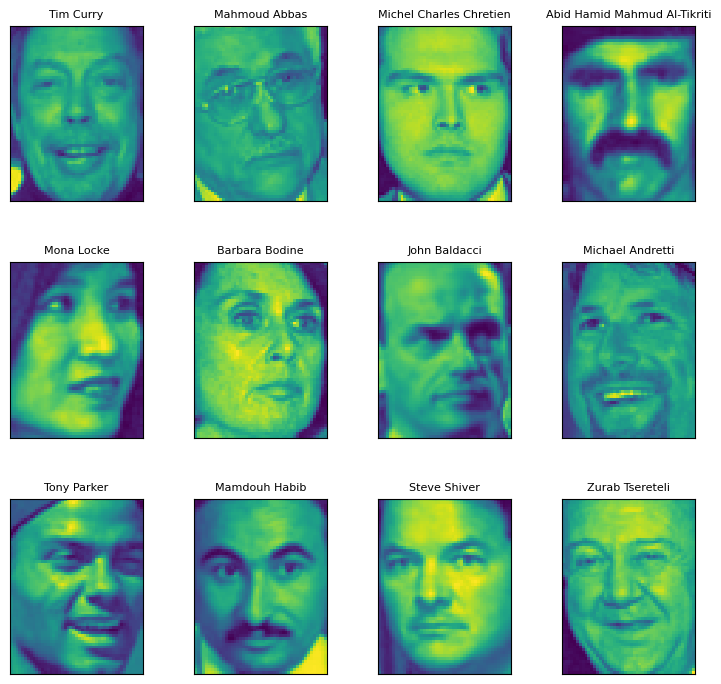

In [4]:
# Función para visualizar una galería de imágenes
# images: conjunto de imágenes a mostrar
# titles: títulos asociados a cada imagen (nombre de la persona)
# h, w: dimensiones (altura, ancho) de cada imagen
# n_row, n_col: cantidad de filas y columnas en la grilla de visualización
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))  # Definir tamaño de la figura
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)  # Espaciado entre imágenes
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)  # Crear cada subgráfico
        plt.imshow(images[i], interpolation='nearest')  # Mostrar imagen
        plt.title(titles[i], size=8)  # Mostrar título (nombre reducido)
        plt.xticks(())  # Quitar marcas de eje x
        plt.yticks(())  # Quitar marcas de eje y

# Generar títulos con los nombres de las personas
titles = [target_names[y[i]] for i in range(12)]

# Llamar a la función para mostrar las primeras 12 imágenes
plot_gallery(lfw_people.images, titles, h, w)

# Mostrar la galería de imágenes
plt.show()

Algo importante a notar, es que el *dataset* está armado como si fuera una base de datos relacional. Es decir, cada imagen posee un *label* numérico que se corresponde al ID del nombre de una persona dentro del *dataset*. Esto se debe a que si bien hay 13233 imágenes, sólo son 5749 personas, por lo que sus IDs van a estar repetidos más de una vez dentro del conjunto de datos **`y`**. Dentro del conjunto de datos **`target_names`** tenemos la relación entre cada ID y su respectivo nombre.

### Agregado de datos usando la API de Wikipedia

Para cumplir con el objetivo de clasificar a las personas por genero, se deben generar los labels de género de cada una de estas personas y asociarlas a cada una de sus imágenes.

Con este fin, inicialmente se tomará el conjunto de datos **`target_names`** y se lo convertirá a formato **dataframe**. Se guardarán los datos en formato **CSV** para revisar los mismos de manera manual.

In [5]:
# Crear un DataFrame solo con los nombres únicos
target_names_df = pd.DataFrame({
    'Label_ID': range(len(target_names)),  # ID numérico (posición en el array)
    'Label_Name': target_names             # Nombre de la persona
})

# Guardar el DataFrame en un archivo CSV
target_names_df.to_csv('lfw_target_names.csv', index=False)

print("Archivo 'lfw_target_names.csv' creado exitosamente.")

Archivo 'lfw_target_names.csv' creado exitosamente.


El siguiente paso será utilizar la API de Wikipedia para determinar los géneros de cada una de las personas en el *dataset*.
Dado que cada persona en el *dataset* es una personalidad conocida, se asume que posee una página de Wikipedia propia.

Wikipedia posee una API propia que es una interfaz que permite consultar información de Wikipedia de forma automática, sin necesidad de abrir el navegador manualmente. Funciona mediante peticiones HTTP (normalmente `GET` o `POST`) que devuelven los datos en formatos como **JSON** o **XML**. En otras palabras, es como hablar directamente con Wikipedia a través de código, enviando una "pregunta estructurada" y recibiendo una "respuesta organizada" con la información solicitada.

Para poder hacer uso de esta API existe una librería de Python llamada **`wikipedia`**, que actúa como un "cliente" para la API de Wikipedia. Esta librería permite:

- **Crea automáticamente** las peticiones HTTP correctas.
- **Maneja** errores como ambigüedad o páginas no encontradas.
- **Devuelve** la información de Wikipedia en objetos Python fáciles de usar (por ejemplo, el título, el contenido o la URL del artículo).

Por ejemplo, con una sola línea:

```python
page = wikipedia.page('Barack Obama')
```

Se hace internamente toda la conexión a la API y se recupera el contenido completo de la página de Barack Obama, listo para ser utilizado en el *script*.

A continuación se crea una función denominada `detect_gender_with_wikiapi()` que busca un determinado nombre y se encarga de obtener párrafo de la descripción general de la página de wikipedia de la persona en cuestión, y determina si el género de dicha persona es **Male** o **Female** en base a los pronombres usados. Si se utilizar "*he*" , entonces se asume que la persona es **Male**. Si por el contrario el pronombre para describir a la persona es "*she*", se asume que es **Female**. Si ninguno de los dos pronombres está presente, se determina que el género es **Unknown**.

> **Nota:** Esta función puede tomar hasta **145 minutos** para ejecutarse y completar la columna **Gender**.

In [ ]:
# Función para detectar el género leyendo toda la introducción de la biografía
def detect_gender_with_wikiapi(name):
    try:
        # Buscar la página de Wikipedia más relevante para ese nombre
        page = wiki.page(name, auto_suggest=False)

        # Obtener todo el contenido de la página
        content = page.content

        # Extraer la introducción: tomamos todo hasta la primera sección importante
        intro_end_idx = content.find('\n==')
        if intro_end_idx != -1:
            intro = content[:intro_end_idx]
        else:
            intro = content  # Si no hay secciones, usamos todo el contenido

        intro_lower = intro.lower()

        # Detectar género buscando pronombres en la introducción
        if ' he ' in intro_lower:
            return 'Male'
        elif ' she ' in intro_lower:
            return 'Female'
        else:
            return 'Unknown'
    except Exception as e:
        # Si ocurre un error (página no encontrada, ambigüedad, etc.)
        return 'Unknown'

# Cargar o crear el CSV
csv_path = 'lfw_target_names_and_gender.csv'

if os.path.exists(csv_path):
    print("Archivo existente encontrado. Cargando...")
    target_names_df = pd.read_csv(csv_path)
else:
    print("Archivo no encontrado. Creando nuevo...")
    target_names_df = pd.DataFrame({
        'Label_ID': range(len(target_names)),  # Asume que 'target_names' está cargado
        'Label_Name': target_names,
        'Gender': ['Unknown'] * len(target_names)
    })
    target_names_df.to_csv(csv_path, index=False)
    print("Archivo creado exitosamente.")

# Detectar género en nombres faltantes
counter = 0

for idx, row in target_names_df.iterrows():
    if row['Gender'] == 'Unknown':
        name = row['Label_Name']
        gender = detect_gender_with_wikiapi(name)
        target_names_df.at[idx, 'Gender'] = gender
        counter += 1

        # Mostrar progreso
        print(f"[{idx}] {name} → {gender}")

        # Cada 100 nombres guardamos avance
        if counter % 100 == 0:
            target_names_df.to_csv(csv_path, index=False)
            print(f"Avance guardado después de {counter} nombres.")

        # Pausa entre consultas para evitar bloqueo por parte de Wikipedia
        time.sleep(0.75)

# Guardar definitivamente el archivo
target_names_df.to_csv(csv_path, index=False)
print("Archivo final actualizado y guardado correctamente.")

Una vez que ejecutada la función debemos verificar la efectividad de la misma, por lo que se imprimirán las cantidades obtenidas en cada caso.

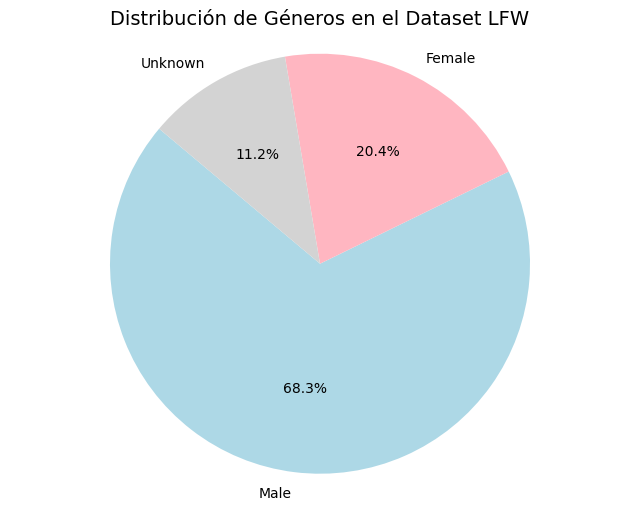

In [6]:
# Cargar el archivo CSV con los nombres y géneros
df = pd.read_csv('lfw_target_names_and_gender.csv')

# Contar la cantidad de ocurrencias de cada género
gender_counts = df['Gender'].value_counts()

# Definir los colores según el género
color_mapping = {
    'Male': 'lightblue',
    'Female': 'lightpink',
    'Unknown': 'lightgray'
}

# Obtener los colores en el orden correcto según los labels
colors = [color_mapping[gender] for gender in gender_counts.index]

# Crear un gráfico de torta para visualizar la distribución de géneros
plt.figure(figsize=(8, 6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',         # Mostrar el porcentaje en cada sección
    startangle=140,            # Rotar el gráfico para mejor orientación
    colors=colors              # Aplicar los colores personalizados
)

plt.title('Distribución de Géneros en el Dataset LFW', fontsize=14)
plt.axis('equal')  # Mantener proporción de círculo
plt.show()

La función fue capaz de detectar al 47% de los nombres como género masculino, pero sólo a un 15% como género femenino, de manera tal que el segundo grupo más grande son los no identificados con el 37%. Si bien la efectividad no fue muy alta, nos permite avanzar con un segundo proceso para tratar de determinar el género de la mayor cantidad de nombres posibles.

Dado que la cantidad de personas en en el *dataset* es tan grande, muchos nombres de pila se repiten, de esta manera tenemos más de un "James", por ejemplo. Si al menos una persona con ese nombre ha sido identificada como de género masculino, podemos considerar que las demás llamadas "James" también son del mismo género. Con esta premisa se construye la función `infer_gender_by_first_name()`, la cual:
- Carga el CSV existente con la columna Gender.
- Extrae el primer nombre (nombre de pila) de cada persona.
- Construye un diccionario de referencia a partir de los nombres ya clasificados (Male o Female).
- Recorre nuevamente todos los registros con género Unknown, y si su primer nombre aparece en el diccionario, les asigna el mismo género.
- Guarda el nuevo CSV actualizado.

In [7]:
def infer_gender_by_first_name(csv_path):
    # Cargar el archivo CSV
    df = pd.read_csv(csv_path)

    # Asegurarse de que la columna 'Gender' exista
    if 'Gender' not in df.columns or 'Label_Name' not in df.columns:
        raise ValueError("El CSV debe contener las columnas 'Label_Name' y 'Gender'.")

    # Extraer el primer nombre (nombre de pila)
    df['First_Name'] = df['Label_Name'].apply(lambda x: x.split()[0] if isinstance(x, str) else '')

    # Crear diccionario: primer nombre → género más frecuente (entre los que ya tienen género asignado)
    known_genders = df[df['Gender'].isin(['Male', 'Female'])]
    name_gender_map = known_genders.groupby('First_Name')['Gender'].agg(lambda x: x.value_counts().idxmax()).to_dict()

    # Reasignar género a los Unknown si su primer nombre aparece en el diccionario
    updated_count = 0
    for i, row in df[df['Gender'] == 'Unknown'].iterrows():
        first_name = row['First_Name']
        if first_name in name_gender_map:
            df.at[i, 'Gender'] = name_gender_map[first_name]
            updated_count += 1

    # Guardar archivo actualizado
    df.drop(columns='First_Name', inplace=True)
    df.to_csv(csv_path, index=False)

    print(f"Actualización completada. {updated_count} géneros fueron inferidos por nombre de pila.")

# Ejecutar
infer_gender_by_first_name('lfw_target_names_and_gender.csv')


Actualización completada. 0 géneros fueron inferidos por nombre de pila.


Luego de correr la función `infer_gender_by_first_name()` se consigue determinar el género de 1510 nombre adicionales. Volvemos entonces a determinar los porcentajes de cada género en el archivo **CSV** generado.

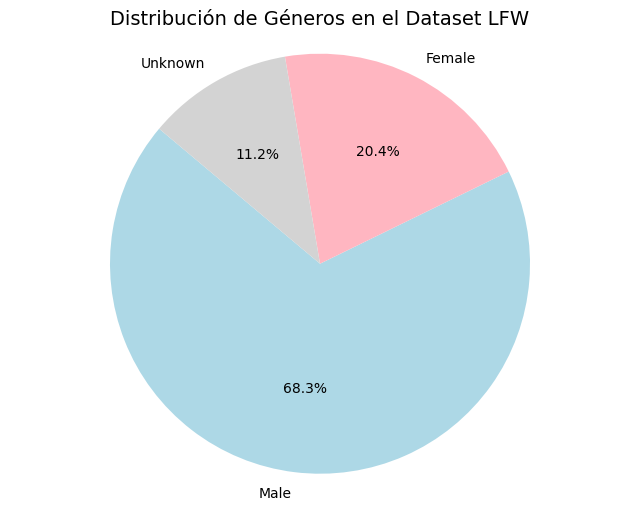

In [8]:
# Cargar el archivo CSV con los nombres y géneros
df = pd.read_csv('lfw_target_names_and_gender.csv')

# Contar la cantidad de ocurrencias de cada género
gender_counts = df['Gender'].value_counts()

# Definir los colores según el género
color_mapping = {
    'Male': 'lightblue',
    'Female': 'lightpink',
    'Unknown': 'lightgray'
}

# Obtener los colores en el orden correcto según los labels
colors = [color_mapping[gender] for gender in gender_counts.index]

# Crear un gráfico de torta para visualizar la distribución de géneros
plt.figure(figsize=(8, 6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',         # Mostrar el porcentaje en cada sección
    startangle=140,            # Rotar el gráfico para mejor orientación
    colors=colors              # Aplicar los colores personalizados
)

plt.title('Distribución de Géneros en el Dataset LFW', fontsize=14)
plt.axis('equal')  # Mantener proporción de círculo
plt.show()

En este caso solo el 11.2% de los nombres se mantienen con un género desconocido, pero los conocidos suman el 88.7%, por lo que concluimos que las *labels* generadas son suficientes para entrenar un modelo de clasificación que permita distinguir entre géneros basados en las imágenes de esas personas.

También es importante notar que el *dataset* posee una desproporción muy grande entre los rostros de varones y mujeres. Aproximadamente solo 1 de cada 5 nombres pertenece a una mujer. En consecuencia se puede inferir que el *dataset* de imágenes posee más imágenes de hombres que de mujeres, por lo que para entrenar un clasificador por género se deberá tomar dos posibles caminos:
- Se entrena un clasificador que detecte varones, y todo lo que no sea un varón sea considerado mujer.
- Se entrena un clasificador de doble salida, donde se identifican hombres y mujeres, pero para ello el *dataset* de entrenamiento deberá estar balanceado para que posea una cantidad idéntica de instancias de ambos géneros.

### Cantidad de Imágenes por Individuo

A continuación se determinará cuantas imágenes de cada persona hay en el dataframe. Esto puede ser determinado a partir de los datos de los *labels* guardados en **y**. Cada valor de **y** se corresponde con el *label* (nombre) de una persona, por lo que si se cuentan la cantidad de veces que cada número se repite, se determina la cantidad de imágenes que existen en el *dataset* de una persona en particular.

Antes de llevar a cabo este paso, se guardan los datos en un archivo en formato CSV, con el fin de poder acceder a los mismos de forma independiente y sin la necesidad de descargar el *dataset*.

In [9]:
# Convertir 'y' a DataFrame
y_df = pd.DataFrame(y, columns=['Label_ID'])

# Guardar el DataFrame como archivo CSV
y_df.to_csv('lfw_targets.csv', index=False)

print("Archivo 'lfw_targets.csv' guardado exitosamente.")

Archivo 'lfw_targets.csv' guardado exitosamente.


El siguiente paso crear un gráfico de barras con la información de la cantidad de imágenes por persona.

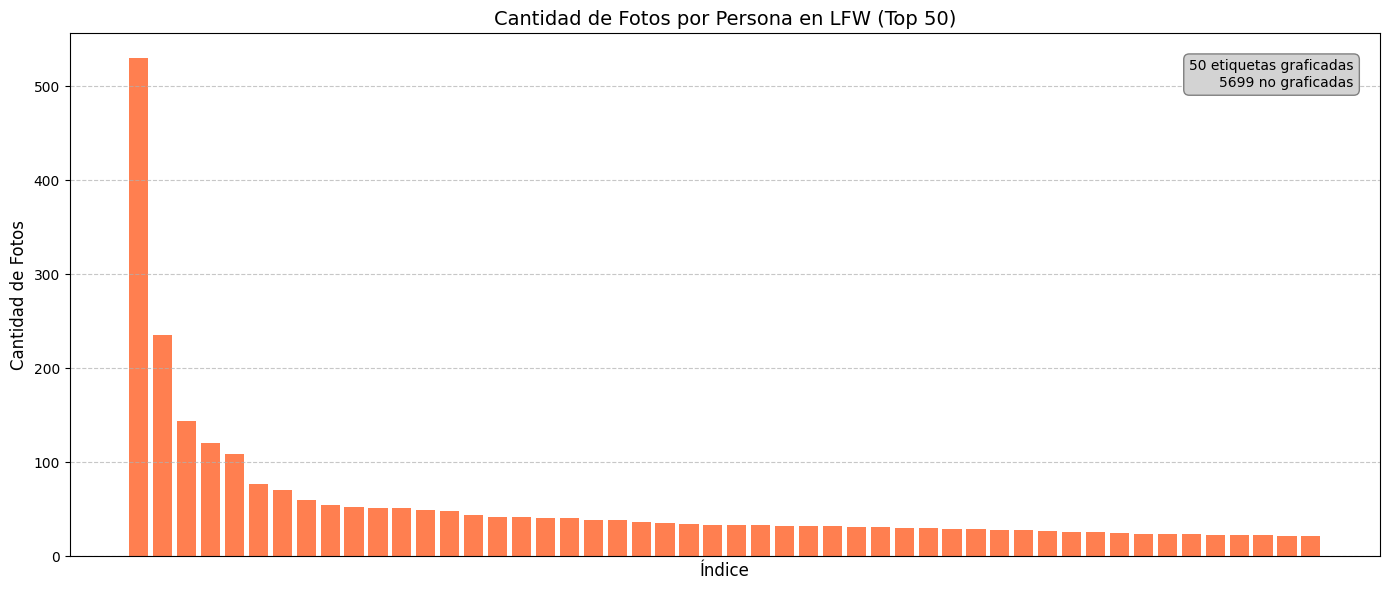

In [10]:
# Cargar el CSV que contiene los IDs de los targets
y_df = pd.read_csv('lfw_targets.csv')

# Contar cuántas veces aparece cada Label_ID
label_counts = Counter(y_df['Label_ID'])

# Crear un DataFrame con los resultados
photo_count_df = pd.DataFrame({
    'Label_ID': list(label_counts.keys()),
    'Photo_Count': list(label_counts.values())
})

# Ordenar por cantidad de fotos (de mayor a menor)
photo_count_df = photo_count_df.sort_values(by='Photo_Count', ascending=False).reset_index(drop=True)

# Limitar a los primeros 50
max_labels = 50
filtered_df = photo_count_df.head(max_labels)

# Cálculo de métricas para mostrar
plotted_count = len(filtered_df)
excluded_count = len(photo_count_df) - plotted_count

# Graficar
plt.figure(figsize=(14, 6))
plt.bar(filtered_df.index, filtered_df['Photo_Count'], color='coral')

plt.xlabel('Índice', fontsize=12)
plt.ylabel('Cantidad de Fotos', fontsize=12)
plt.title('Cantidad de Fotos por Persona en LFW (Top 50)', fontsize=14)

# Agregar recuadro informativo dentro del gráfico
info_text = f'{plotted_count} etiquetas graficadas\n{excluded_count} no graficadas'
plt.gca().text(
    0.98, 0.95, info_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', edgecolor='gray')
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([])  # Eliminar etiquetas del eje X
plt.tight_layout()
plt.show()

Este gráfico muestra los *labels* del *dataset* (es decir, el índice del nombre de cada persona) de mayor a menor, graficando las cantidades de los primeros 50. Como se observa, el mínimo está en 22 fotos, por lo que las 5699 personas que están en el *dataset* poseen 22 imágenes o menos.

Considerando los valores obtenidos, se calculan algunas métricas auxiliares: máximo, mínimo, media, moda, mediana y cuartiles. Además, se buscarán las 10 personas con mayor cantidad de fotos. Estas serán las personas para las cuales entrenaremos el clasificador que busca determinar personal autorizado de personal no autorizado.

In [11]:
# Unir para agregar los nombres
photo_count_df = photo_count_df.merge(target_names_df, on='Label_ID')

# Mostrar Top 10 personas más fotografiadas
top_10 = photo_count_df.sort_values(by='Photo_Count', ascending=False).head(10)

print("\nTop 10 personas con más imágenes:")
print(top_10[['Label_Name', 'Photo_Count']])

# Calcular estadísticas
photo_counts_list = photo_count_df['Photo_Count'].tolist()

mean_photos = sum(photo_counts_list) / len(photo_counts_list)
median_photos = stats.median(photo_counts_list)
mode_photos = stats.mode(photo_counts_list)
min_photos = min(photo_counts_list)
max_photos = max(photo_counts_list)

# Calcular cuartiles
quartiles = np.percentile(photo_counts_list, [25, 50, 75])

print("\nEstadísticas de cantidad de fotos por persona:")
print(f"Media (promedio): {mean_photos:.2f}")
print(f"Mediana: {median_photos}")
print(f"Moda: {mode_photos}")
print(f"Mínimo: {min_photos}")
print(f"Máximo: {max_photos}")
print(f"Primer cuartil (Q1, 25%): {quartiles[0]}")
print(f"Segundo cuartil (Q2, 50% - Mediana): {quartiles[1]}")
print(f"Tercer cuartil (Q3, 75%): {quartiles[2]}")



Top 10 personas con más imágenes:
          Label_Name  Photo_Count
0      George W Bush          530
1       Colin Powell          236
2         Tony Blair          144
3    Donald Rumsfeld          121
4  Gerhard Schroeder          109
5       Ariel Sharon           77
6        Hugo Chavez           71
7  Junichiro Koizumi           60
8      Jean Chretien           55
9      John Ashcroft           53

Estadísticas de cantidad de fotos por persona:
Media (promedio): 2.30
Mediana: 1
Moda: 1
Mínimo: 1
Máximo: 530
Primer cuartil (Q1, 25%): 1.0
Segundo cuartil (Q2, 50% - Mediana): 1.0
Tercer cuartil (Q3, 75%): 2.0


Al generar las estadísticas del *dataset* encontramos que la mayoría de las personas posee sólo una foto y que el promedio de hecho se encuntra influenciado por el máximo de 530. Esto implica que sólo las primeras 10 personas que poseen suficientes fotos podrían ser consideradas dentro del *dataset* de entrenamiento para ser identificadas por el modelo. Las demás no poseen suficientes instancias como para entrenar un clasificador y que el mismo lleve a cabo la selección correctamente.

Aprovechando la función `plot_gallery()` creada previamente, se imprimen las imágenes de las 10 personas con mayor cantidad de imágenes en el *dataset*.

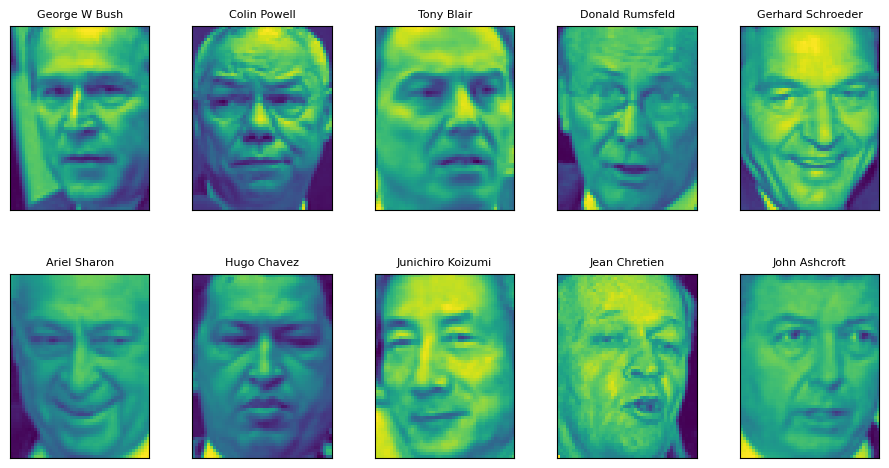

In [12]:
# Obtener las Label_IDs de las 10 personas más populares
top_10_label_ids = top_10['Label_ID'].tolist()

# Filtrar imágenes correspondientes a esas personas
selected_images = []
selected_titles = []

# Limitar cantidad de imágenes para visualización (ej: 1 por persona)
for label_id in top_10_label_ids:
    indices = (lfw_people.target == label_id).nonzero()[0]
    if len(indices) > 0:
        selected_images.append(lfw_people.images[indices[0]])  # Tomar la primera imagen
        selected_titles.append(target_names_df.loc[target_names_df['Label_ID'] == label_id, 'Label_Name'].values[0])

# Mostrar galería
plot_gallery(selected_images, selected_titles, lfw_people.images.shape[1], lfw_people.images.shape[2],
             n_row=2, n_col=5)
plt.show()

## Reconocimiento de Personas Autorizadas

### Preparación de los Datos

Habiendo analizado el *dataset*, el siguiente paso a llevar a cabo es separar los datos para generar un *train set* y un *test set*. Dado que estamos interesados en entrenar algoritmos de clasificación para detectar a las 10 personas con mayor cantidad de imagenes en el *dataset*, es necesario primero separar las imágenes de estas personas de forma proporcional en ambos conjuntos (*train* y *test set*), y luego sumar cada sub *dataset* al resto de las imágenes también separadas en los sub *datasets* ya mensionados.

In [13]:
# Crear una máscara para identificar las imágenes que pertenecen a las 10 personas más fotografiadas
mask_top10 = np.isin(y, top_10_label_ids)

# Obtener los índices de las imágenes que corresponden al top 10 y al resto de personas
indices_top10 = np.where(mask_top10)[0]
indices_rest = np.where(~mask_top10)[0]

# Extraer las imágenes (X) y sus etiquetas (y) del top 10
X_top10 = X[indices_top10]
y_top10 = y[indices_top10]

# Dividir las imágenes del top 10 en conjuntos de entrenamiento y prueba,
# manteniendo proporciones similares de imágenes por persona (estratificación)
X_train_top10, X_test_top10, y_train_top10, y_test_top10, idx_train_top10, idx_test_top10 = train_test_split(
    X_top10,
    y_top10,
    indices_top10,
    test_size=0.2,
    stratify=y_top10,
    random_state=42
)

# Extraer las imágenes del resto de las personas
X_rest = X[indices_rest]
y_rest = y[indices_rest]

# Dividir las imágenes del resto de las personas en entrenamiento y prueba de forma aleatoria
X_train_rest, X_test_rest, y_train_rest, y_test_rest = train_test_split(
    X_rest,
    y_rest,
    test_size=0.2,
    random_state=42
)

# Unir las divisiones del top 10 y del resto para obtener los datasets finales
X_train = np.concatenate([X_train_top10, X_train_rest])
y_train = np.concatenate([y_train_top10, y_train_rest])

X_test = np.concatenate([X_test_top10, X_test_rest])
y_test = np.concatenate([y_test_top10, y_test_rest])

# Mostrar estadísticas básicas para verificar que se mantiene la proporción de las 10 personas
print("Total de imágenes de entrenamiento:", len(X_train))
print("Total de imágenes de prueba:", len(X_test))

Total de imágenes de entrenamiento: 10585
Total de imágenes de prueba: 2648


De esta manera se puede determinar qué cantidad de imágenes de cada persona quedaron tanto en el *train set* como en el *test set*, junto a sus correspondientes índices.

In [14]:
# Crear un DataFrame con las cantidades de imágenes por persona en train y test
train_counts = pd.Series(y_train).value_counts().rename('Train_Count')
test_counts = pd.Series(y_test).value_counts().rename('Test_Count')

# Combinar con los nombres desde target_names_df
summary_df = top_10[['Label_ID', 'Label_Name']].copy()
summary_df = summary_df.merge(train_counts, left_on='Label_ID', right_index=True, how='left')
summary_df = summary_df.merge(test_counts, left_on='Label_ID', right_index=True, how='left')

# Mostrar la tabla
print("\nResumen de imágenes por persona en los conjuntos de entrenamiento y prueba:")
print(summary_df)


Resumen de imágenes por persona en los conjuntos de entrenamiento y prueba:
   Label_ID         Label_Name  Train_Count  Test_Count
0      1871      George W Bush          424         106
1      1047       Colin Powell          189          47
2      5458         Tony Blair          115          29
3      1404    Donald Rumsfeld           97          24
4      1892  Gerhard Schroeder           87          22
5       373       Ariel Sharon           61          16
6      2175        Hugo Chavez           57          14
7      2941  Junichiro Koizumi           48          12
8      2453      Jean Chretien           44          11
9      2682      John Ashcroft           42          11


### Clasificador Binario

Ahora que hemos separado el *dataset* en *train set* y *test set*, procederemos a instaciar un clasificador binario, es decir, es un modelo que determina si una instancia pertenece a una determinada clase o no. En este caso utilizaremos la clase *Stochastic Gradient Decent Classifier* (`SDGClassifier`) de *Scikit-Learn*.

Para evaluar el clasificador, utilizaremos algunas métricas muy utilizadas en este tipo de modelos:

- **Precision (Precisión)**: La precisión mide cuántas de las predicciones positivas realizadas por el modelo fueron realmente positivas.

    $\text{Precision} = \frac{TP}{TP + FP}$

- **Recall (Sensibilidad o Exhaustividad)**: El recall mide cuántas de las instancias realmente positivas fueron correctamente detectadas por el modelo.

    $\text{Recall} = \frac{TP}{TP + FN}$

- **F1 Score**: La F1 Score es la media armónica entre precisión y recall. Es útil cuando queremos un balance entre ambos.

    $F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

> **Nota**: Los valores **TP** son los verdades positivos, los valores **FP** son los falsos positivos y finalmente los **FN** son los falsos negativos.


              precision    recall  f1-score   support

     No Bush       0.98      0.97      0.97      2542
        Bush       0.41      0.57      0.48       106

    accuracy                           0.95      2648
   macro avg       0.70      0.77      0.73      2648
weighted avg       0.96      0.95      0.95      2648



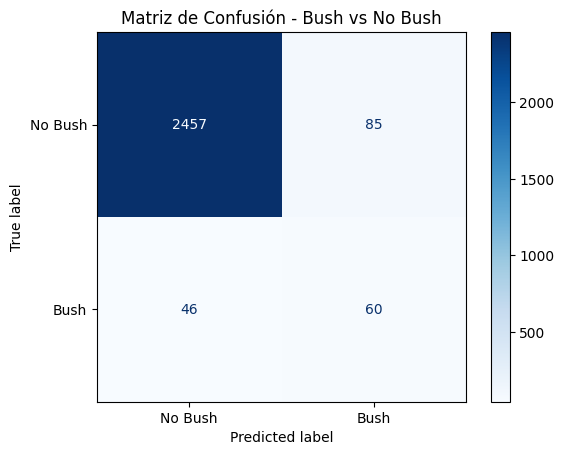

In [25]:
# Seleccionar el label ID de George W. Bush (según top_10 se identificó como 1871)
# Creamos un vector binario donde True indica que la imagen pertenece a Bush
y_train_gwb = (y_train == 1871)
y_test_gwb = (y_test == 1871)

# Entrenar un clasificador lineal usando Stochastic Gradient Descent para detectar si una imagen es de Bush o no
sgd_clf_gwb = SGDClassifier(random_state=42)
sgd_clf_gwb.fit(X_train, y_train_gwb)

# Predecir las etiquetas del conjunto de test usando el modelo entrenado
# Esto nos da una predicción booleana: True si el modelo cree que es Bush, False si no
y_pred = sgd_clf_gwb.predict(X_test)

# Imprimir un informe de clasificación que incluye:
# - Precisión (precision): cuántas predicciones positivas fueron correctas
# - Recall (sensibilidad): cuántos casos positivos fueron detectados
# - F1-score: media armónica entre precisión y recall
# - Soporte: cantidad real de ejemplos por clase
# El parámetro target_names da nombres legibles a las clases: 0 = "No Bush", 1 = "Bush"
print(classification_report(y_test_gwb, y_pred, target_names=["No Bush", "Bush"]))

# Generar la matriz de confusión, que muestra:
# - Verdaderos negativos (TN): correctamente clasificados como "No Bush"
# - Falsos positivos (FP): incorrectamente clasificados como "Bush"
# - Falsos negativos (FN): casos de Bush que no fueron detectados
# - Verdaderos positivos (TP): correctamente clasificados como "Bush"
cm = confusion_matrix(y_test_gwb, y_pred)

# Visualizar la matriz de confusión con etiquetas
# Esto ayuda a interpretar el rendimiento del modelo de manera visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Bush", "Bush"])
disp.plot(cmap='Blues')  # Se elige un mapa de color azul para mejor visibilidad

# Título del gráfico
plt.title("Matriz de Confusión - Bush vs No Bush")
plt.show()

Como se puede observar, el clasificador no posee muy buenos resultados, lo cual se debe a que el *dataset* está desbalanceado. Se puede tratar de determinar las curvas de precisión y recall utilizando la función `cross_val_predict()`que en lugar de devolver las predicciones, devuelve los *scores* de decisión en cada instancia.

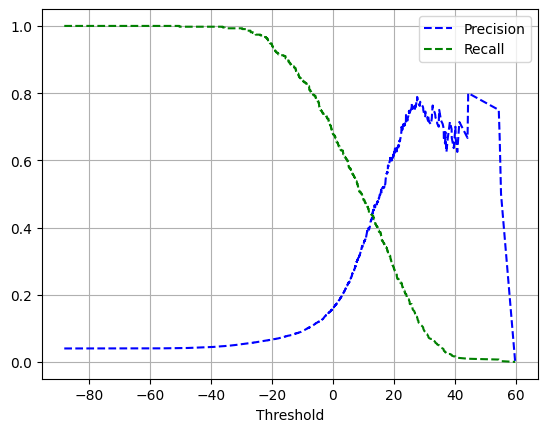

In [28]:
y_scores = cross_val_predict(sgd_clf_gwb, X_train, y_train_gwb, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_gwb, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()